## Example - Inlet & Street Drainage Model

This example illustrates how to model street inlets with SWMM. 
The same 39 acre study area used in the sample Site Drainage Model will be analyzed. 
Instead of using only surface swales and culverts to convey runoff off of the site, a series of streets and below ground sewers has been added. 
There are five street conduits that run through subcatchments S1, S2, and S7. 
Four of these contain inlet drains that divert captured street runoff flow into a system of below ground sewer pipes (P1 to P8).

To gain a better understanding of how the model is setup, do following ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swmm_api
print(f'{swmm_api.__version__ = }')

swmm_api.__version__ = '0.4.59'


In [3]:
from swmm_api import SwmmInput, SwmmOutput, SwmmReport
from swmm_api.run_swmm import swmm5_run_progress
from swmm_api.run_swmm.run_temporary import swmm5_run_temporary
from swmm_api.input_file.macros import links_dict

In [5]:
inp = SwmmInput('Inlet_Drains_Model.inp')

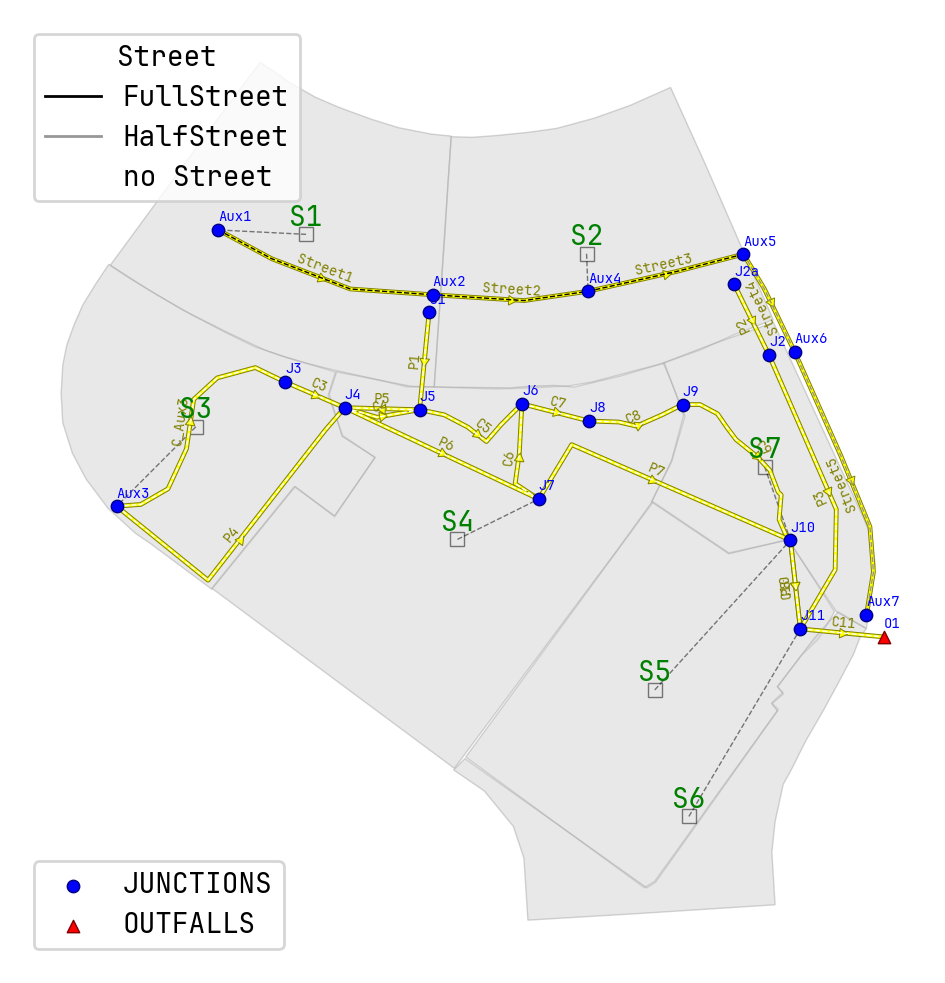

In [6]:
from swmm_api.input_file.macros.plotting_map import add_subcatchment_map, init_empty_map_plot, add_node_map, add_link_map, add_node_labels, add_link_labels, add_subcatchments_labels
fig, ax = init_empty_map_plot()

add_subcatchment_map(ax, inp)
add_link_map(ax, inp, add_arrows=True)
add_node_labels(ax, inp, ha='left', y_offset=15, size=5, color='blue')
add_link_labels(ax, inp, y_offset=10, size=5, color='olive')
add_subcatchments_labels(ax, inp, size=10, y_offset=15, color='green')

add_link_map(ax, inp, 
             values_dict={l: 'no Street' if not (l in inp.XSECTIONS and (inp.XSECTIONS[l].shape == 'STREET')) else inp.XSECTIONS[l].street for l in links_dict(inp)}, 
             line_width_default=0.5, 
             ls='--', 
             cmap='Greys_r',
             # color='black', 
             discrete=True, 
             add_border_line=False, 
             colorbar_kwargs={'title': 'Street', 'loc':'upper left'})
add_node_map(ax, inp)

### 1. 
Select the Streets category from the Project Browser and view the properties of the two types of street cross-sections made available to the model.

In [7]:
inp.STREETS

{   'HalfStreet': Street(name='HalfStreet', width_crown=20.0, height_curb=0.5, slope=4.0, n_road=0.016, depth_gutter=0.0, width_gutter=0.0, sides=1, width_backing=20.0, slope_backing=4.0, n_backing=0.016),
    'FullStreet': Street(name='FullStreet', width_crown=20.0, height_curb=0.5, slope=4.0, n_road=0.016, depth_gutter=0.0, width_gutter=0.0, sides=2, width_backing=20.0, slope_backing=4.0, n_backing=0.016)}

### 2. 
Open the Property Editor for Street1 and by selecting to edit its Shape property you can see which Street cross-section design was assigned to it. 

In [8]:
inp.XSECTIONS['Street1']

CrossSection(link='Street1', shape='STREET', height=nan, transect=nan, street='FullStreet', parameter_2=nan, curve_name=nan, parameter_3=0.0, parameter_4=0.0, n_barrels=1, culvert=nan)

In [9]:
inp.XSECTIONS['Street1'].street

'FullStreet'

Do the same for Street5 and note that it was assigned a different type of Street cross-section.

In [10]:
inp.XSECTIONS['Street5'].street

'HalfStreet'

### 3. 
Now see what inlet designs have been defined for the project by selecting the Inlets category from the Project Browser. 
There is just one design available whose properties can be viewed by selecting to edit it.

In [11]:
inp.INLETS

{   ('ComboInlet', 'GRATE'): InletGrate(name='ComboInlet', kind='GRATE', length=2.0, width=2.0, grate_type='P_BAR-50', area_open=nan, velocity_splash=nan),
    ('ComboInlet', 'CURB'): InletCurb(name='ComboInlet', kind='CURB', length=2.0, height=0.5, throat_angle='HORIZONTAL')}

### 4. 
Next see how inlets have been assigned to streets by using Street3 as an example. 
Bring it into the Property Editor, select the Inlets property and click the ellipsis button. 
An Inlet Usage Editor will appear where you can see that the ComboInlet inlet design has been assigned to it whose captured flow is sent to node J2a. 
(If the Display Link Symbols map option is in effect an inlet symbol will appear on the street conduit as will a dotted line between the conduit's downstream node and the inlet's capture node).

In [12]:
inp.INLET_USAGE

{   'Street1': InletUsage(conduit='Street1', inlet='ComboInlet', node='J1', num=1, clogged_pct=0.0, flow_max=0.0, height_gutter=0.0, width_gutter=0.0, placement=nan),
    'Street3': InletUsage(conduit='Street3', inlet='ComboInlet', node='J2a', num=1, clogged_pct=0.0, flow_max=0.0, height_gutter=0.0, width_gutter=0.0, placement=nan),
    'Street4': InletUsage(conduit='Street4', inlet='ComboInlet', node='J2', num=1, clogged_pct=0.0, flow_max=0.0, height_gutter=0.0, width_gutter=0.0, placement=nan),
    'Street5': InletUsage(conduit='Street5', inlet='ComboInlet', node='J11', num=2, clogged_pct=0.0, flow_max=0.0, height_gutter=0.0, width_gutter=0.0, placement=nan)}

In [13]:
inp.INLET_USAGE['Street3']

InletUsage(conduit='Street3', inlet='ComboInlet', node='J2a', num=1, clogged_pct=0.0, flow_max=0.0, height_gutter=0.0, width_gutter=0.0, placement=nan)


Run the model for the 2-year design storm event and view the Street Flow table in the Summary Report. 
Note that the maximum spread of runoff across the site's streets ranges from 5 to 10 feet. 
If the allowable spread to maintain traffic safety was the width of one lane (which is 10 feet for the streets in this project) then this arrangement of inlets would be acceptable.

In [14]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_progress, label='example_run_swmm') as res:
    rpt = res.rpt  # type: SwmmReport
    out = res.out  # type: SwmmOutput

swmm5 /var/folders/3v/lct6k8mn02xdl7r3zg30bjl00000gn/T/tmpa13vaa_o/example_run_swmm.inp:   0%|          | 0/10…

In [15]:
rpt.street_flow_summary

Peak_Flow_CFS  Maximum_Spread_ft  Maximum_Depth_ft  \
StreetConduit                                                       
Street1                7.291              7.826             0.313   
Street2                2.027              8.274             0.331   
Street3                9.524              9.712             0.388   
Street4                3.814              7.181             0.287   
Street5                1.187              4.258             0.170   

              Inlet_Design Inlet_Location  Inlet_Count  \
StreetConduit                                            
Street1         ComboInlet       ON-GRADE          1.0   
Street2               None           None          NaN   
Street3         ComboInlet       ON-GRADE          1.0   
Street4         ComboInlet       ON-GRADE          1.0   
Street5         ComboInlet         ON-SAG          2.0   

               Peak_Flow_Capture_Pcnt  Avg._Flow_Capture_Pcnt  \
StreetConduit                                                   
Street1                         60.82                   92.34   
Street2                           NaN                     NaN   
Street3                         56.71                   91.87   
Street4                         61.52                   92.57   
Street5                         98.00                   90.36   

               Bypass_Flow_Freq_Pcnt  Back_Flow_Freq_Pcnt  \
StreetConduit                                               
Street1                        61.14                 0.00   
Street2                          NaN                  NaN   
Street3                        51.70                 0.00   
Street4                        39.50                 0.00   
Street5                        23.20                 0.87   

               Peak_Capture_/ Inlet_CFS  Peak_Bypass_Flow_CFS  
StreetConduit                                                  
Street1                            2.22                  2.86  
Street2                             NaN                   NaN  
Street3                            2.70                  4.12  
Street4                            2.35                  1.47  
Street5                            0.58                  0.02

In [16]:
rpt.street_flow_summary['Maximum_Spread_ft'].describe()

count    5.000000
mean     7.450200
std      2.012351
min      4.258000
25%      7.181000
50%      7.826000
75%      8.274000
max      9.712000
Name: Maximum_Spread_ft, dtype: float64